In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_timeseries(metric, label):
    args  = {'skiprows' : 13, 'names': ["index", "Time (sec)", label]}
    fname = DIR + metric + '.wsp.out'
    try:
        df = pd.read_csv(fname, **args)
    except:
        sys.exit("Create time series (" + fname + ") does not exist, "+
                 "please cd to pipelines/hep/visualize and run ./plot.sh")    
    del df['index']
    df = df[df['Time (sec)'] != 0]
    return df

def trim(mod, axis):
    for i in range(0, len(axis)):
        if i % mod != 0:
            axis[i] = ""
    axis[0] = ""
    return axis

# annotate graph with job phases
def plot_phases(ax, metric, label, y0=1000, y1=2000, xshift=0):
    def to_seconds(timestamp):
        ts = timestamp.split(':')
        return int(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    
    args  = {'skiprows' : 13, 'names': ["index", "Time (sec)", label]}
    fname = DIR + metric + '.wsp.out'
    try:
        df = pd.read_csv(fname, **args)
    except:
        sys.exit("Create time series (" + fname + ") does not exist, "+
                 "please cd to pipelines/hep/visualize and run ./plot.sh")
    t = float(df.head(1)['Time (sec)'])
    print t
    ax.annotate(label, xy=(t, y0), xytext=(t+xshift, y1),
        ha='center', arrowprops=dict(facecolor='black'))
    return t
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

def parse(expdir):
    df = pd.DataFrame(columns=['job', 'rtime', 'ts'])
    with open(expdir + '/summary.txt') as f:
        d = pd.read_csv(f, names=['job', 'delta', 'time'])
        d['rtime'] = d['delta'].apply(to_seconds)
        del d['time'], d['delta']
        d['run'] = 0
        df = df.append(d, ignore_index=True)
    return df.pivot(index='run', values='rtime', columns='job')


1518038779.0
1518038858.0


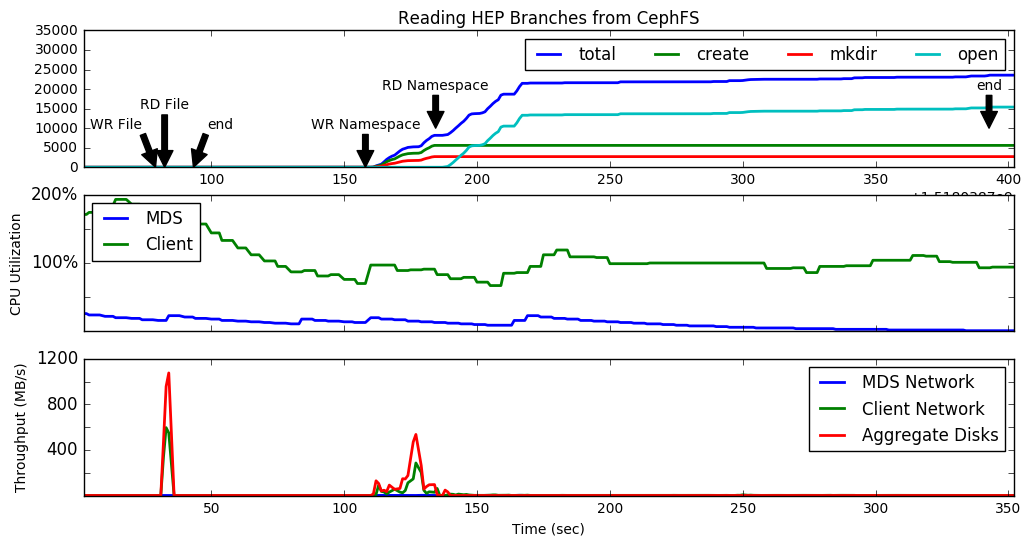

In [3]:
DIR = "../results-monitor0/"
START = 1518038452+300
END   = 1518038452+650
df = read_timeseries('handle_client_request', 'total')
for req in ['create', 'mkdir', 'open']:
    df = pd.merge(df, read_timeseries('req_'+req, req), on='Time (sec)')

fig, ax = plt.subplots(3, 1, figsize=(12, 6))
args = {'x': 'Time (sec)', 'lw': 2}
df.plot(ax=ax[0], y=['total', 'create', 'mkdir', 'open'], **args)
ax[0].set_xlim(START, END)
ax[0].set_title("Reading HEP Branches from CephFS")
ax[0].legend(loc='upper right', ncol=4)

df_util = read_timeseries('node-4-avg1', 'MDS')
df_util = pd.merge(df_util, read_timeseries('avg1', 'Client'), on='Time (sec)')
df_util.plot(ax=ax[1], y=['MDS', 'Client'], **args)
ax[1].set_xlim(START, END)
ax[1].set_ylabel("CPU Utilization")
ax[1].set_yticklabels(trim(2, ['{:3.0f}%'.format(y*100) for y in ax[1].get_yticks()]), fontsize=12)
ax[1].legend(fontsize=12, loc='upper left')
ax[1].set_xticklabels([]); ax[1].set_xlabel("")

for req in ['node-4-kbin', 'node-4-kbout',
            'node-0-kbin', 'node-0-kbout',
            'node1-sdc', 'node2-sdc', 'node3-sdc']:
    df_util = pd.merge(df_util, read_timeseries(req, req), on='Time (sec)')
df_util['Client Network'] = df_util['node-0-kbin'] + df_util['node-0-kbout']
df_util['MDS Network'] = df_util['node-4-kbin'] + df_util['node-4-kbout']
df_util['Aggregate Disks'] = df_util['node1-sdc'] + df_util['node2-sdc'] + df_util['node3-sdc']
df_util.plot(ax=ax[2], y=['MDS Network', 'Client Network', 'Aggregate Disks'], **args)
ax[2].set_ylabel("Throughput (MB/s)")
ax[2].set_xlim(START, END)
ax[2].set_yticklabels(trim(2, ['{:3.0f}'.format(y/1000) for y in ax[2].get_yticks()]), fontsize=12)
ax[2].set_xticklabels(range(0, 400, 50))

args = {'ha'   : 'center', 'arrowprops': dict(facecolor='black')}
runtimes = parse(DIR)
start = plot_phases(ax[0], 'cephfs', 'WR File', y0=0, y1=10000, xshift=-15)
end   = start + runtimes['write_cephfs']
ax[0].annotate('RD File', xy=(end, 0), xytext=(end, 15000), **args)
end   = end + runtimes['read_cephfs']
ax[0].annotate('end', xy=(end, 0), xytext=(end+10, 10000), **args)

start = plot_phases(ax[0], 'fpb_cephfs', 'WR Namespace', y0=0, y1=10000)
end   = start + runtimes['write_fpb_cephfs']
ax[0].annotate('RD Namespace', xy=(end, 10000), xytext=(end, 20000), **args)
end   = end + runtimes['read_fpb_cephfs']
ax[0].annotate('end', xy=(end, 10000), xytext=(end, 20000), **args)


   Time (sec)  total  create  mkdir  open
0  1518059457      1       0      0     0
1  1518059458      1       0      0     0
2  1518059459      1       0      0     0
3  1518059460      1       0      0     0
4  1518059461      1       0      0     0
1518059522.0
1518059839.0


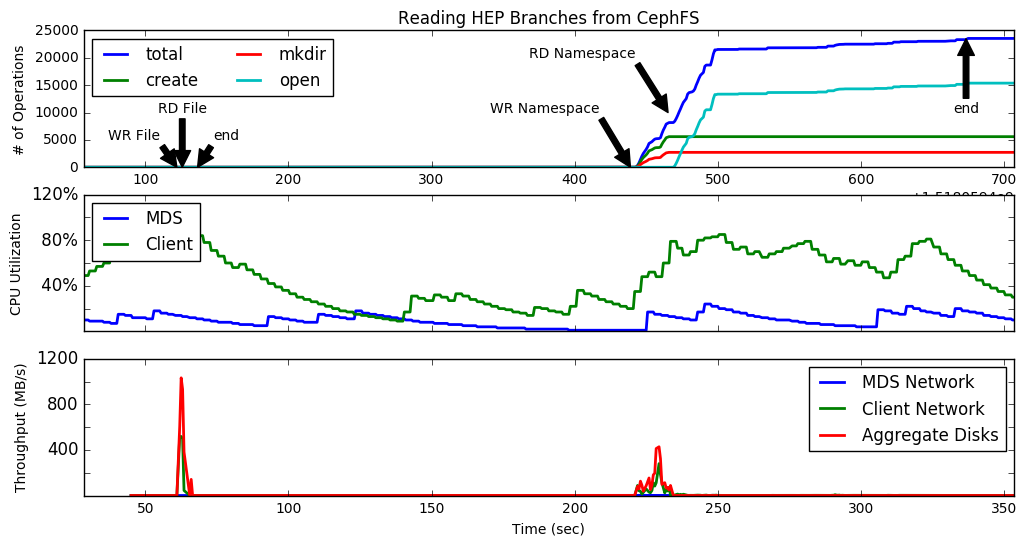

In [4]:
DIR = "../results-monitor-nonetwork-run0/"
START = 1518059457
END   = 1518059457 + 650
df = read_timeseries('handle_client_request', 'total')
for req in ['create', 'mkdir', 'open']:
    df = pd.merge(df, read_timeseries('req_'+req, req), on='Time (sec)')
print df.head()

fig, ax = plt.subplots(3, 1, figsize=(12, 6))
args = {'x': 'Time (sec)', 'lw': 2}
df.plot(ax=ax[0], y=['total', 'create', 'mkdir', 'open'], **args)
ax[0].set_xlim(START, END)
ax[0].set_title("Reading HEP Branches from CephFS")
ax[0].legend(loc='upper left', ncol=2)
ax[0].set_ylim(0, 25000)
ax[0].set_ylabel("# of Operations")

df_util = read_timeseries('avg1', 'MDS')
df_util = pd.merge(df_util, read_timeseries('node-0-avg1', 'Client'), on='Time (sec)')
df_util.plot(ax=ax[1], y=['MDS', 'Client'], **args)
ax[1].set_xlim(START, END)
ax[1].set_ylabel("CPU Utilization")
ax[1].set_yticklabels(trim(2, ['{:3.0f}%'.format(y*100) for y in ax[1].get_yticks()]), fontsize=12)
ax[1].legend(fontsize=12, loc='upper left')
ax[1].set_xticklabels([]); ax[1].set_xlabel("")

for req in ['kbin', 'kbout',
            'node-0-kbin', 'node-0-kbout',
            'node1-sdc', 'node2-sdc', 'node3-sdc']:
    df_util = pd.merge(df_util, read_timeseries(req, req), on='Time (sec)')
df_util['Client Network'] = df_util['node-0-kbin'] + df_util['node-0-kbout']
df_util['MDS Network'] = df_util['kbin'] + df_util['kbout']
df_util['Aggregate Disks'] = df_util['node1-sdc'] + df_util['node2-sdc'] + df_util['node3-sdc']
df_util.plot(ax=ax[2], y=['MDS Network', 'Client Network', 'Aggregate Disks'], **args)
ax[2].set_ylabel("Throughput (MB/s)")
ax[2].set_xlim(START, END)
ax[2].set_yticklabels(trim(2, ['{:3.0f}'.format(y/1000) for y in ax[2].get_yticks()]), fontsize=12)
ax[2].set_xticklabels(range(0, 400, 50))

args = {'ha'   : 'center', 'arrowprops': dict(facecolor='black')}
runtimes = parse(DIR)
start = plot_phases(ax[0], 'cephfs', 'WR File', y0=0, y1=5000, xshift=-30)
end   = start + runtimes['write_cephfs']
ax[0].annotate('RD File', xy=(end, 0), xytext=(end, 10000), **args)
end   = end + runtimes['read_cephfs']
ax[0].annotate('end', xy=(end, 0), xytext=(end+20, 5000), **args)

start = plot_phases(ax[0], 'fpb_cephfs', 'WR Namespace', y0=0, y1=10000, xshift=-60)
end   = start + runtimes['write_fpb_cephfs']
ax[0].annotate('RD Namespace', xy=(end, 10000), xytext=(end-60, 20000), **args)
end   = end + runtimes['read_fpb_cephfs']
ax[0].annotate('end', xy=(end, 23500), xytext=(end, 10000), **args)

plt.savefig('rdwr_branches_trace.png', dpi=300, bbox_inches='tight')

1518059839.0
1518059522.0


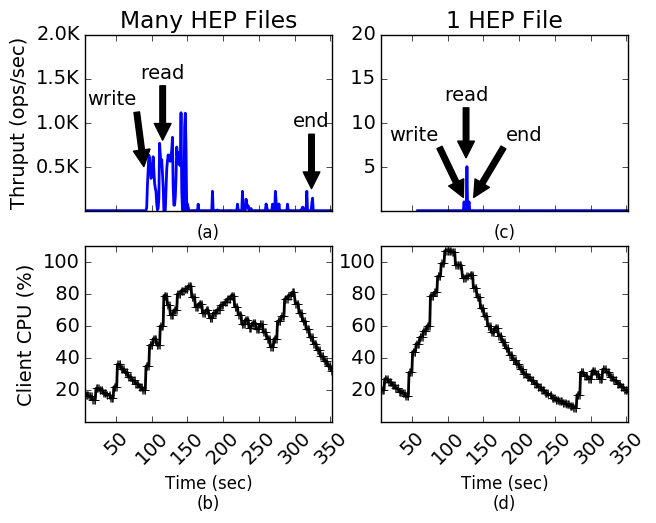

In [23]:
args = {'x': 'Time (sec)', 'lw': 2}
font = {'size'   : 14}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(2, 2, figsize=(7, 5))#2.6))

df = read_timeseries('handle_client_request', 'total')
for req in ['create', 'mkdir', 'open']:
    df = pd.merge(df, read_timeseries('req_'+req, req), on='Time (sec)')
df['total_tput'] = df['total'] - df['total'].shift(1)

df_util = read_timeseries('avg1', 'MDS')
df_util = pd.merge(df_util, read_timeseries('node-0-avg1', 'client'), on='Time (sec)')

START = 1518059457 + 350 - 50
END   = 1518059457 + 645 #550
a = ax[0][0]; a.set_title("Many HEP Files")
df.plot(ax=a, y=['total_tput'], **args)
a.set_xlabel("(a)", fontsize=12); a.set_xticklabels([], rotate=45)
a.set_xlim(START, END)
a.set_ylim(0, 2000)
labels = ['{:3.1f}K'.format(y/1000) for y in a.get_yticks()]; labels[0] = ""
a.set_yticklabels(labels)
a.legend().remove()
a.set_ylabel("Thruput (ops/sec)");

a = ax[1][0]
df_util.plot(ax=a, y=['client'], color='black', marker='+', **args)    
a.set_xlim(START, END)
a.set_yticklabels(trim(1, ['{:3.0f}'.format(y*100) for y in a.get_yticks()]))
a.set_xlabel("Time (sec)\n(b)", fontsize=12); a.set_xticklabels(range(0, 400, 50), fontsize=14, rotation=45)
a.set_ylabel("Client CPU (%)"); a.set_ylim(0, 1.1)
a.legend().remove()

START = 1518059457 - 50
END   = 1518059457 + 295
a = ax[0][1]; a.set_title("1 HEP File")
df.plot(ax=a, y=['total_tput'], **args)
a.set_xlabel("(c)", fontsize=12); a.set_xticklabels([])
a.set_xlim(START, END)
a.set_ylim(0, 20)
labels = ['{:3.0f}'.format(y) for y in a.get_yticks()]; labels[0] = ""
a.set_yticklabels(labels)
a.legend().remove()

a = ax[1][1]
df_util.plot(ax=a, y=['client'], color='black', marker='+', **args)    
a.set_xlim(START, END)
a.set_yticklabels(trim(1, ['{:3.0f}'.format(y*100) for y in a.get_yticks()]))
a.set_xlabel("Time (sec)\n(d)", fontsize=12); a.set_xticklabels(range(0, 400, 50), fontsize=14, rotation=45)
a.set_ylim(0, 1.1)
a.legend().remove()

##### Add the arrows
args = {'ha'   : 'center', 'arrowprops': dict(facecolor='black')}
a = ax[0][0]
start = plot_phases(a, 'fpb_cephfs', 'write', y0=500, y1=1200, xshift=-45)
end   = start + runtimes['write_fpb_cephfs']
a.annotate('read', xy=(end, 800), xytext=(end, 1500), **args)
end   = end + runtimes['read_fpb_cephfs']
a.annotate('end', xy=(end, 250), xytext=(end, 950), **args)

a = ax[0][1]
runtimes = parse(DIR)
start = plot_phases(a, 'cephfs', 'write', y0=1.5, y1=8, xshift=-70)
end   = start + runtimes['write_cephfs']
a.annotate('read', xy=(end, 6), xytext=(end, 12.5), **args)
end   = end + runtimes['read_cephfs']
a.annotate('end', xy=(end, 1.5), xytext=(end+70, 8), **args)

plt.savefig('../../../paper/figures/hep_problem.png', dpi=300, bbox_inches='tight')